/opt/homebrew/Caskroom/miniconda/base/envs/Academy/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/Academy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


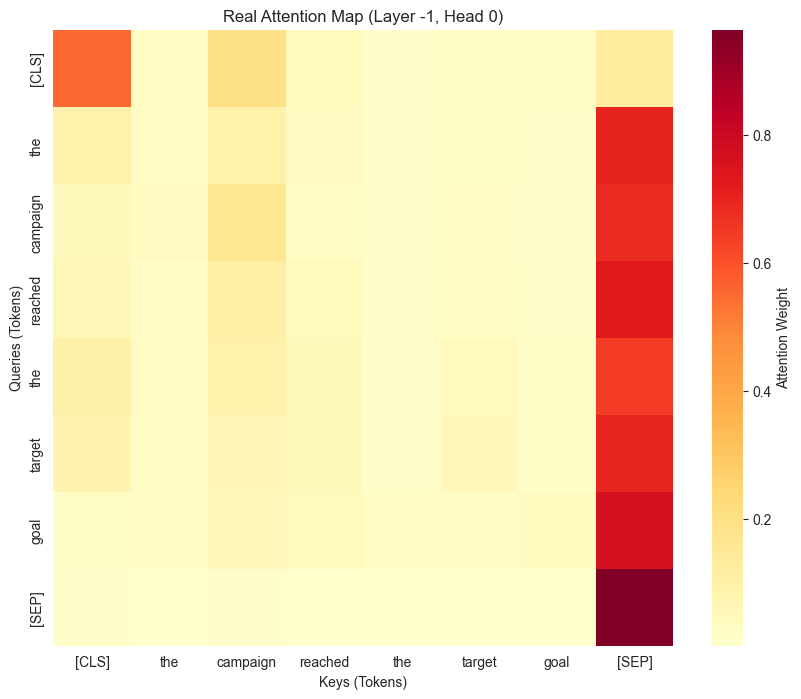

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

text = "The campaign reached the target goal"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

all_attentions = outputs.attentions

layer_index = -1
head_index = 0
attention_matrix = all_attentions[layer_index][0, head_index, :, :]

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix,
            xticklabels=tokens,
            yticklabels=tokens,
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Attention Weight'})

plt.title(f'Real Attention Map (Layer {layer_index}, Head {head_index})')
plt.xlabel('Keys (Tokens)')
plt.ylabel('Queries (Tokens)')
plt.show()

1. The "No-Op" Behavior (High Attention on [SEP])

The most statistically significant feature is the vertical band of high attention weights (indicated by the deep red color, approximating values >0.8) directed toward the [SEP] token at the final index. This is observed across nearly all query tokens (rows).

In the context of BERT interpretability (referencing studies like Clark et al., 2019), this is a documented phenomenon often referred to as a "No-Op" (No-Operation) head.

Mechanism: When a specific attention head does not identify a relevant linguistic relationship (such as syntactic dependency or coreference) between the query token and other tokens in the sequence, the model learns to "park" the attention mass on a delimiter token (typically [SEP] or [CLS]).

Function: This prevents the model from updating the current token's vector representation with irrelevant noise from random words. By attending to [SEP], the token effectively retains its current state or aggregates a neutral signal, acting as a "pass-through" for this specific head.

2. Sparsity of Token-to-Token Interaction

The vast majority of the matrix representing word-to-word interactions (e.g., "campaign" → "reached") exhibits near-zero weights (light yellow).

This indicates that Head 0 of the final layer is not responsible for extracting local semantic features or syntactic dependencies for this specific input sequence.

In a Multi-Head Attention architecture, this "idleness" is expected. The representational capacity is distributed across multiple heads; while Head 0 is effectively dormant (or handling structural housekeeping), other heads in the same layer are likely capturing the semantic relationships.

3. [CLS] Token Behavior

The [CLS] token (Row 0), which serves as the aggregate representation for downstream classification tasks, shows a slightly distinct pattern. While it also heavily attends to [SEP], it retains some attention mass on itself. This is consistent with the [CLS] token's role in the final layer, where it attempts to pool context; however, in this specific head, it is not extracting significant features from the constituent words.